<h1><center><font color = 'blue'>AMSUA N18 CH14 - Exploratory Data Analysis</font></center></h1>

In [1]:
import matplotlib.pyplot as plt
import lightgbm as lgbm
import seaborn as sns
import pandas as pd
import numpy as np
import sys

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats

sys.path.append('FSOI/lib')

import lib_mapping as lmapping
import lib_obimpact as loi
import lib_utils as lutils

### Import

In [2]:
df = pd.read_hdf('Data/amsua12_n18_ch14.h5')

### Split inputs and outputs

In [3]:
X = df.drop(['DATETIME', 'IMPACT', 'OMF'], axis=1)
y = df['IMPACT']/df['OMF']

cols_2D = [col for col in X.columns if not any(char.isdigit() for char in col)]

### Explore y (sensitivity)

In [4]:
y.describe()

count    1.447004e+06
mean    -1.074708e-09
std      6.663472e-07
min     -1.098445e-05
25%     -2.978689e-07
50%      4.049435e-09
75%      2.997277e-07
max      9.279972e-06
dtype: float64

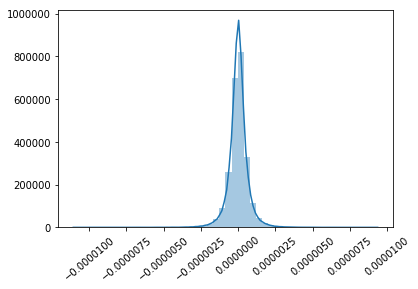

In [5]:
sns.distplot(y)
plt.xticks(rotation=40)
plt.show()

In [6]:
abs(y).describe()

count    1.447004e+06
mean     4.446906e-07
std      4.962559e-07
min      4.867192e-13
25%      1.336196e-07
50%      2.987764e-07
75%      5.786626e-07
max      1.098445e-05
dtype: float64

### y correlations with X variables 

In [7]:
y_corr = X.corrwith(y, axis=0)
print('\n5 largest corr with y:\n{}'.format(y_corr.nlargest()))
print('\n5 smallest corr with y:\n{}'.format(y_corr.nsmallest()))


5 largest corr with y:
v_427.673        0.017663
ozone_100.514    0.017569
v_464.421        0.017135
v_390.897        0.016876
ozone_118.25     0.016803
dtype: float64

5 smallest corr with y:
lon            -0.025013
LONGITUDE      -0.025012
ozone_21.761   -0.020533
tv_15.05       -0.020359
sphu_0.14      -0.020171
dtype: float64


### Train and predict (Linear Regression & Gradient Boosting)

In [8]:
# split train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [9]:
# train Linear Regression
lr = LinearRegression()
lr.fit(X_train[cols_2D], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [10]:
# train Gradient Boosting
gbm = lgbm.LGBMRegressor(objective='regression', n_estimators=300, learning_rate=0.1, random_state=10)

gbm.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_names=('train', 'test'),
    eval_metric='l2',
    early_stopping_rounds=20,
    feature_name=X_train.columns.tolist(),
    verbose=False
)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=300,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=10,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)

In [11]:
# predict LR
lr_pred = lr.predict(X_test[cols_2D])

In [12]:
# predict GBM
gbm_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
gbm_train = gbm.predict(X_train, num_iteration=gbm.best_iteration_)

### Results

#### Linear Regression

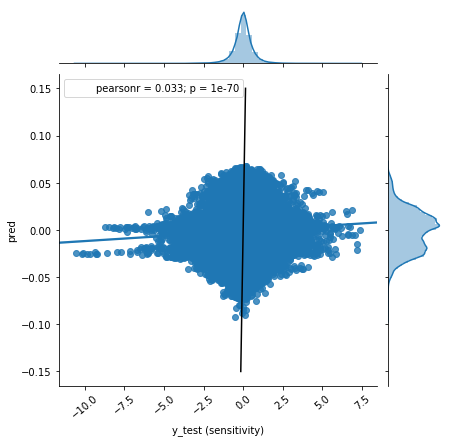

In [25]:
ax = sns.jointplot(x=y_test*1e6 , y=lr_pred*1e6, kind="reg")
ax.annotate(stats.pearsonr)
ax.set_axis_labels(xlabel='y_test (sensitivity)', ylabel='pred')
# add bissectrice (in black)
plt.plot([-0.15, 0.15], [-0.15, 0.15], 'k-')
# prevent x axis labels overlapping
plt.xticks(rotation=40)
plt.show()

#### Gradient Boosting

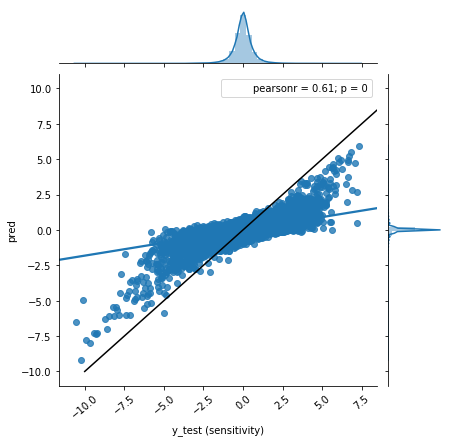

In [28]:
ax = sns.jointplot(x=y_test*1e6 , y=gbm_pred*1e6, kind="reg")
ax.annotate(stats.pearsonr)
ax.set_axis_labels(xlabel='y_test (sensitivity)', ylabel='pred')
# add bissectrice (in black)
plt.plot([-10, 10], [-10, 10], 'k-')
# prevent x axis labels overlapping
plt.xticks(rotation=40)
plt.show()

#### Mean Squared Error on test sample

In [29]:
print('Only zeros MSE:        {0:.4g}' .format(mean_squared_error(y_test, [0]*len(y_test))))
print('LR MSE:                {0:.4g}' .format(mean_squared_error(y_test, lr_pred)))
print('GBM MSE:               {0:.4g}' .format(mean_squared_error(y_test, gbm_pred)))
print('GBM with a factor MSE: {0:.4g}' .format(mean_squared_error(y_test, 2.5*gbm_pred)))

Only zeros MSE:        4.428e-13
LR MSE:                4.423e-13
GBM MSE:               3.21e-13
GBM with a factor MSE: 2.854e-13


#### Mean Squared Error on train sample

In [30]:
print('Only zeros MSE:        {0:.4g}' .format(mean_squared_error(y_train, [0]*len(y_train))))
print('GBM MSE:               {0:.4g}' .format(mean_squared_error(y_train, gbm_train)))
print('GBM with a factor MSE: {0:.4g}' .format(mean_squared_error(y_train, 2.5*gbm_train)))

Only zeros MSE:        4.443e-13
GBM MSE:               3.098e-13
GBM with a factor MSE: 2.722e-13


#### Compute statistics about real sensitivity and pred sensitivity ratio

In [17]:
ratio = pd.Series(y_test/gbm_pred)
ratio.describe()

count    289401.000000
mean          1.393869
std        1573.910568
min     -485049.403694
25%          -2.540588
50%           1.887087
75%           6.517717
max      394042.678819
dtype: float64

#### Display ratio pdf

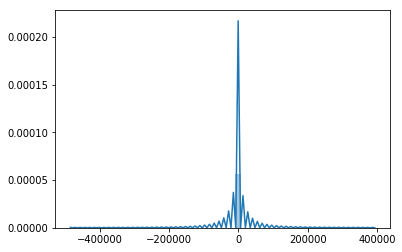

In [18]:
ax = sns.distplot(ratio, norm_hist=True)

#### % of ratio values between ]-5:5[

In [19]:
print('{0:.2f}%' .format(len(ratio[(ratio > -5) & (ratio < 5)])/len(ratio)*100))

50.60%


#### Display ratio between ]-5:5[ pdf

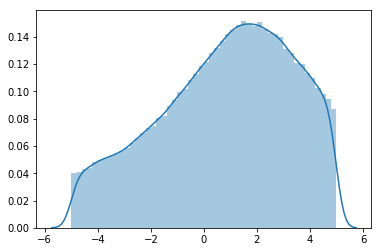

In [20]:
filtered = ratio[(ratio > -5) & (ratio < 5)]
ax = sns.distplot(filtered)

#### % of ratio values between ]0.5:1.5[

In [21]:
print('{0:.2f}%' .format(len(ratio[(ratio > 0.5) & (ratio < 1.5)])/len(ratio)*100))

7.22%


#### % of ratio negative sign

In [22]:
print('{0:.2f}%' .format(len(ratio[ratio < 0])/len(ratio)*100))

36.64%


#### % of ratio values ≈ 0

In [23]:
print('{0:.2f}%' .format(len(ratio[abs(ratio) < 1e-3])/len(ratio)*100))

0.01%


#### plot ratio map

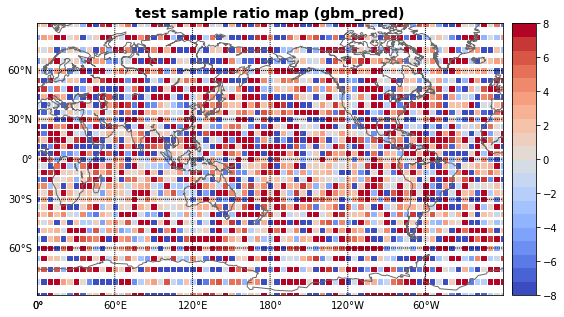

In [24]:
# build lat and lon dict to recode coord to 5dgx5dg boxes
# get lat and lon obs possible value
lat_keys = np.arange(-90., 90.1, 0.1)
lon_keys = np.arange(0., 360.1, 0.1)

# get new lat and lon possible values
lat_new = np.arange(-90, 90.1, 5.0)
lon_new = np.arange(0, 360.1, 5.0)

# for each possible values get the nearest among new values
lat_values = [sorted(lat_new, key=lambda x: abs(x - lat))[0] for lat in lat_keys]
lon_values = [sorted(lon_new, key=lambda x: abs(x - lon))[0] for lon in lon_keys]

# join keys and values into dict
lat_dict = dict(zip(np.round(lat_keys, 1), lat_values))
lon_dict = dict(zip(np.round(lon_keys, 1), lon_values))

# get data
df_ratio = pd.concat([X_test[['LONGITUDE', 'LATITUDE']], ratio],
                     ignore_index=True, axis=1)

df_ratio.columns = ['lon', 'lat', 'ratio']

# recode lon
mask_lon = df_ratio[df_ratio['lon'] < 0].index.tolist()
df_ratio.loc[mask_lon, 'lon'] = df_ratio.loc[mask_lon, 'lon'] + 360

# recode coord
df_ratio['new_lat'] = df_ratio.lat.map(lambda x: lat_dict[np.round(x, 1)])
df_ratio['new_lon'] = df_ratio.lon.map(lambda x: lon_dict[np.round(x, 1)])

# init colormap
cmap = plt.cm.get_cmap(name='coolwarm', lut=20)

# aggregate values with mean
means = df_ratio.groupby(['new_lon', 'new_lat'])['ratio'].agg('mean').reset_index()

lats = means['new_lat'].values
lons = means['new_lon'].values
ratios = means['ratio'].values

# create a basemap object and project coord
proj = lmapping.Projection('mill', resolution='c', llcrnrlat=-80., urcrnrlat=80.)
bmap = lmapping.createMap(proj)
x, y = bmap(lons, lats)

# ready to plot now!
plt.figure(figsize=(10, 5))
plt.title('test sample ratio map (gbm_pred)',
          fontdict={'size': 14, 'weight': 'semibold'})

lmapping.drawMap(bmap, proj, fillcontinents=False)

sc = bmap.scatter(x, y, c=ratios, s=20, marker='s', cmap=cmap, alpha=1.0,
                  edgecolors='face', vmin=-8, vmax=8)

bmap.colorbar(sc, 'right', size='5%', pad='2%')